# Yale Hydropower Model

## Rocky River Powerplant

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import datetime, calendar

In [5]:
# Load data
stream_flow_data_path = './data/StreamFlowData.csv'
stream_flow_df = pd.read_csv(stream_flow_data_path)
stream_flow_df = stream_flow_df.drop(['Unnamed: 0', 'agency_cd', 'site_no', 'X_00060_00003_cd'], axis=1)
stream_flow_df = stream_flow_df.rename(columns={"Date":"Date", "X_00060_00003":"CFS"})
stream_flow_df['Date'] = pd.to_datetime(stream_flow_df['Date'], format='%m/%d/%Y')
# filter out 1993-2021
df_stream = stream_flow_df[(stream_flow_df['Date'] >= '1993-01-01') & (stream_flow_df['Date'] < '2023-01-01')]

In [6]:
# df_stream = df_stream.set_index('Date')
CFS = list(df_stream['CFS'])
Dates = list(df_stream['Date'])
print(CFS)
print(Dates)

[6110.0, 5350.0, 4280.0, 3720.0, 4530.0, 6080.0, 5900.0, 5360.0, 4480.0, 3460.0, 2940.0, 2680.0, 2630.0, 2590.0, 2380.0, 2210.0, 2050.0, 1700.0, 1500.0, 1410.0, 1650.0, 1850.0, 2260.0, 2310.0, 2280.0, 2680.0, 2920.0, 2890.0, 2640.0, 2340.0, 2010.0, 1690.0, 1550.0, 1300.0, 1300.0, 1250.0, 1280.0, 1150.0, 1050.0, 1000.0, 978.0, 1020.0, 1030.0, 1040.0, 1070.0, 1090.0, 1030.0, 1460.0, 1200.0, 1050.0, 1000.0, 920.0, 860.0, 1050.0, 1040.0, 900.0, 830.0, 780.0, 760.0, 830.0, 848.0, 816.0, 815.0, 701.0, 777.0, 889.0, 821.0, 940.0, 1060.0, 1000.0, 928.0, 700.0, 520.0, 709.0, 1120.0, 1240.0, 1100.0, 1000.0, 1820.0, 1630.0, 1440.0, 1410.0, 2570.0, 3730.0, 4480.0, 5810.0, 7710.0, 9650.0, 11700.0, 12600.0, 12800.0, 12100.0, 10200.0, 8030.0, 6390.0, 5560.0, 5130.0, 5010.0, 5170.0, 5530.0, 6790.0, 7410.0, 7420.0, 6800.0, 6090.0, 5020.0, 5800.0, 6250.0, 6050.0, 5560.0, 4610.0, 5450.0, 7540.0, 7420.0, 6930.0, 6260.0, 6730.0, 6330.0, 5510.0, 4670.0, 3890.0, 3320.0, 2950.0, 2600.0, 2340.0, 2410.0, 2340.0

In [12]:
def find_minima(s):
    n = len(s)
    minima_loc = [0]
    for i in range(1, n - 1):
        if s[i] <= s[i - 1] and s[i] <= s[i + 1]:
            minima_loc.append(i)
    minima_loc.append(n-1)
    return minima_loc

def interpolate_minima(s, minima):
    new_s = []
    for i in range(len(minima) - 1):
        diff = s[minima[i + 1]] - s[minima[i]]
        interval = diff / (minima[i + 1] - minima[i])
        for j in range(minima[i + 1] - minima[i]):
            new_s.append(s[minima[i]] + j * interval)
    new_s.append(s[-1])
    return new_s



In [13]:
CFS_minima = find_minima(CFS)
CFS_interpolated = interpolate_minima(CFS, CFS_minima)
print(CFS)
print(CFS_interpolated)

[6110.0, 5350.0, 4280.0, 3720.0, 4530.0, 6080.0, 5900.0, 5360.0, 4480.0, 3460.0, 2940.0, 2680.0, 2630.0, 2590.0, 2380.0, 2210.0, 2050.0, 1700.0, 1500.0, 1410.0, 1650.0, 1850.0, 2260.0, 2310.0, 2280.0, 2680.0, 2920.0, 2890.0, 2640.0, 2340.0, 2010.0, 1690.0, 1550.0, 1300.0, 1300.0, 1250.0, 1280.0, 1150.0, 1050.0, 1000.0, 978.0, 1020.0, 1030.0, 1040.0, 1070.0, 1090.0, 1030.0, 1460.0, 1200.0, 1050.0, 1000.0, 920.0, 860.0, 1050.0, 1040.0, 900.0, 830.0, 780.0, 760.0, 830.0, 848.0, 816.0, 815.0, 701.0, 777.0, 889.0, 821.0, 940.0, 1060.0, 1000.0, 928.0, 700.0, 520.0, 709.0, 1120.0, 1240.0, 1100.0, 1000.0, 1820.0, 1630.0, 1440.0, 1410.0, 2570.0, 3730.0, 4480.0, 5810.0, 7710.0, 9650.0, 11700.0, 12600.0, 12800.0, 12100.0, 10200.0, 8030.0, 6390.0, 5560.0, 5130.0, 5010.0, 5170.0, 5530.0, 6790.0, 7410.0, 7420.0, 6800.0, 6090.0, 5020.0, 5800.0, 6250.0, 6050.0, 5560.0, 4610.0, 5450.0, 7540.0, 7420.0, 6930.0, 6260.0, 6730.0, 6330.0, 5510.0, 4670.0, 3890.0, 3320.0, 2950.0, 2600.0, 2340.0, 2410.0, 2340.0

## IGNORE BELOW THIS FOR NOW. THIS WAS OLD WORK.

<AxesSubplot: >

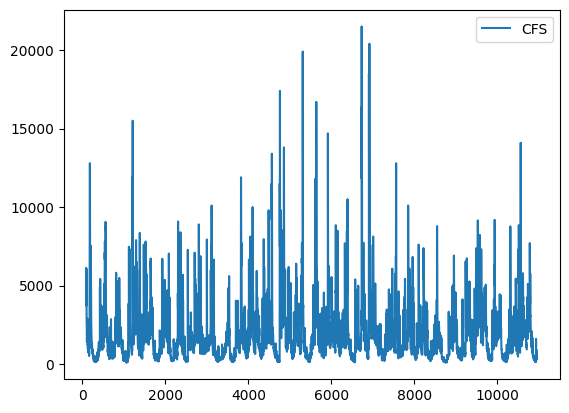

In [52]:
# year = 1996
# start_range = str(year) + "-01-01"
# end_range = str(year) + "-12-31"
# century = df_stream[start_range:end_range]
df_stream.plot(y='CFS', use_index=True)

In [26]:
# df_stream['SMA5'] = df_stream['CFS'].rolling(30).mean()
# df_stream.dropna(inplace=True)
# df_stream[['CFS', 'SMA5']].plot(label='df_stream', figsize=(16, 8))
# plt.axhline(y=np.nanmean(df_stream['SMA5']))


In [27]:
# Gets the dates for a given month in a given year
def get_dates(year, month):
    weeks = calendar.monthcalendar(year, month)
    dates = []
    for w in weeks:
        for d in w:
            if d != 0 and d not in dates:
                dates.append(d)
    return dates

In [28]:
# Gets formatted dates for every day in the year 2035 and stores in date_strings
# Associated data for all years stored in date_CFS
date_strings = []
date_CFS = []
for i in range(12):
    md = get_dates(2035, i + 1)
    date_string = '2035-' + str(i + 1).zfill(2) + '-'
    for d in md:
        temp_date_string = date_string + str(d).zfill(2)
        date_strings.append(temp_date_string)
        date_CFS.append(np.asarray(df_stream.loc[(df_stream.index.month==i+1) & (df_stream.index.day==d)]).flatten())

print(date_strings)

['2035-01-01', '2035-01-02', '2035-01-03', '2035-01-04', '2035-01-05', '2035-01-06', '2035-01-07', '2035-01-08', '2035-01-09', '2035-01-10', '2035-01-11', '2035-01-12', '2035-01-13', '2035-01-14', '2035-01-15', '2035-01-16', '2035-01-17', '2035-01-18', '2035-01-19', '2035-01-20', '2035-01-21', '2035-01-22', '2035-01-23', '2035-01-24', '2035-01-25', '2035-01-26', '2035-01-27', '2035-01-28', '2035-01-29', '2035-01-30', '2035-01-31', '2035-02-01', '2035-02-02', '2035-02-03', '2035-02-04', '2035-02-05', '2035-02-06', '2035-02-07', '2035-02-08', '2035-02-09', '2035-02-10', '2035-02-11', '2035-02-12', '2035-02-13', '2035-02-14', '2035-02-15', '2035-02-16', '2035-02-17', '2035-02-18', '2035-02-19', '2035-02-20', '2035-02-21', '2035-02-22', '2035-02-23', '2035-02-24', '2035-02-25', '2035-02-26', '2035-02-27', '2035-02-28', '2035-03-01', '2035-03-02', '2035-03-03', '2035-03-04', '2035-03-05', '2035-03-06', '2035-03-07', '2035-03-08', '2035-03-09', '2035-03-10', '2035-03-11', '2035-03-12', '2035

In [29]:
# Fromats data for every day in a year with date, median flow rate, max flow rate and minimum flow rate
# max flow rate = min(med + std, maximum)
# min flow rate = max(med - std, minimum)
year_data = []
for i in range(len(date_strings)):
    current_date_data = [date_strings[i]]
    a = date_CFS[i]
    current_date_data.append(np.median(a))
    current_date_data.append(min(np.median(a) + np.std(a), np.max(a)))
    current_date_data.append(max(np.median(a) - np.std(a), np.min(a)))
    year_data.append(current_date_data)

year_data = np.array(year_data)

In [30]:
# Builds dataframe and adds date as datetime
df = pd.DataFrame(year_data, columns = ['date', 'median', 'min', 'max'])
df['date'] = pd.to_datetime(df['date'])

In [46]:
# df_stream['SMA5'] = df_stream['CFS'].rolling(30).mean()
# df_stream.dropna(inplace=True)
# df_stream[['CFS', 'SMA5']].plot(label='df_stream', figsize=(16, 8))
# plt.axhline(y=np.nanmean(df_stream['SMA5']))
# sns.lineplot(x='date', y='min', data=df)
mi = list(df['min'])
ma = list(df['max'])
me = list(df['median'])

# df.plot(y='min', use_index=True)
# print(df.index)
# print(me)
# x = np.arange(1, len(me) + 1, 1)
# plt.plot(x, mi)
# plt.plot(x, me)
# plt.plot(x, ma)